In [1]:
import sys
import os


sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))

import utils
import torch

from torchvision import datasets
import torchvision.transforms as T
import models

from conf import global_settings as settings
from utils_train import dataset_loader

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.setup_seed(0)

In [3]:
training_loader, test_loader, perm = dataset_loader(
    'cifar10',
    settings.CIFAR10_TRAIN_MEAN,
    settings.CIFAR10_TRAIN_STD,
    num_workers = 4,
    batch_size = 32,
    shuffle=True,
    shuffle_pixels = True
)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
img = next(iter(training_loader))[0][0]

img.shape

torch.Size([3, 32, 32])

In [5]:
img_ordered = perm.ordenar(img.unsqueeze(0)).squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


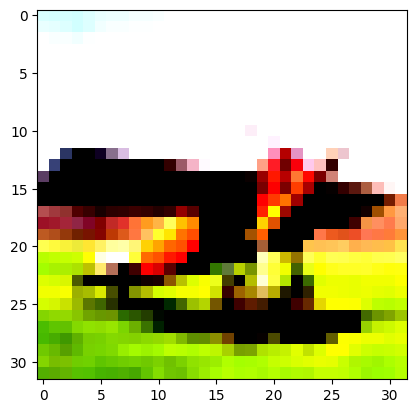

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img_ordered.permute(1,2,0))

In [6]:
%pip install torchinfo

You should consider upgrading via the 'c:\Users\nelso\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [80]:
import sys
import os

sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))


from torchinfo import summary
from models import vgg_permuted
import utils

perm = utils.Permutar(32,1)

vgg = vgg_permuted.vgg16_bn_deformable(perm,2)

summary(vgg, input_size=(2, 3, 32, 32))

(2, 32, 32)
(2, 32, 32)
(2, 16, 16)
(2, 16, 16)
(2, 8, 8)
(2, 8, 8)
(2, 8, 8)
(2, 4, 4)
(2, 4, 4)
(2, 4, 4)
(2, 2, 2)
(2, 2, 2)
(2, 2, 2)


Layer (type:depth-idx)                   Output Shape              Param #
VGG_permuted                             [2, 100]                  --
├─DeformConv2d: 1-1                      [2, 64, 32, 32]           1,792
├─BatchNorm2d: 1-2                       [2, 64, 32, 32]           128
├─DeformConv2d: 1-3                      [2, 64, 32, 32]           36,928
├─BatchNorm2d: 1-4                       [2, 64, 32, 32]           128
├─DeformMaxPool2d: 1-5                   [2, 64, 16, 16]           --
├─DeformConv2d: 1-6                      [2, 128, 16, 16]          73,856
├─BatchNorm2d: 1-7                       [2, 128, 16, 16]          256
├─DeformConv2d: 1-8                      [2, 128, 16, 16]          147,584
├─BatchNorm2d: 1-9                       [2, 128, 16, 16]          256
├─DeformMaxPool2d: 1-10                  [2, 128, 8, 8]            --
├─DeformConv2d: 1-11                     [2, 256, 8, 8]            295,168
├─BatchNorm2d: 1-12                      [2, 256, 8, 8]     

In [78]:
import sys
import os

sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))

import torch
import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

my_tensor = torch.tensor([[1, 2, 3,4],
                       [5, 6,7,8],
                       [9,5,9,19],
                          [13,14,17,29]]).to(device).float()

my_tensor = my_tensor.unsqueeze(0).unsqueeze(0)

my_tensor = my_tensor.repeat(2,1,1,1)

perm = utils.Permutar(4,1)

my_tensor_permuted = perm.desordenar(my_tensor)

In [76]:
pool = utils.DeformMaxPool2d(4, perm, 3)
pool.new_perm.ordenar(pool(my_tensor_permuted))

tensor([[[[10.]]],


        [[[10.]]]])

In [12]:
perm.ordenar(result)

tensor([[[[ 6.,  8.],
          [14., 16.]]],


        [[[ 6.,  8.],
          [14., 16.]]]])

In [79]:
from torch import nn

m = nn.MaxPool2d(3)
m(my_tensor)

tensor([[[[9.]]],


        [[[9.]]]])

In [139]:
output = torch.load('output.pt')
output_deformed = torch.load('output_deformed.pt')

print(output.shape, output_deformed.shape)

output = output.squeeze()
output_deformed = output_deformed.squeeze()


torch.Size([64, 64, 32, 32]) torch.Size([64, 64, 32, 32])


In [103]:
output.shape, output_deformed.shape

(torch.Size([64, 512]), torch.Size([64, 512]))

In [140]:
output[0,0,0,0], output_deformed[0,0,0,0]

(tensor(-0.1447), tensor(-0.3719))

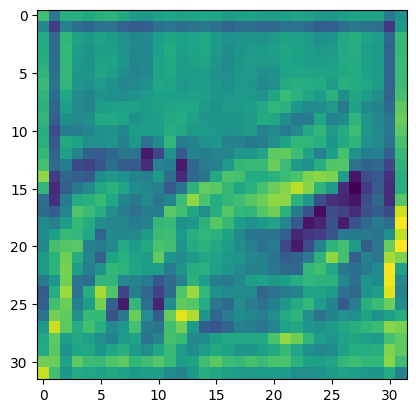

In [141]:
plt.imshow(output[10,0,:,:].detach().numpy())

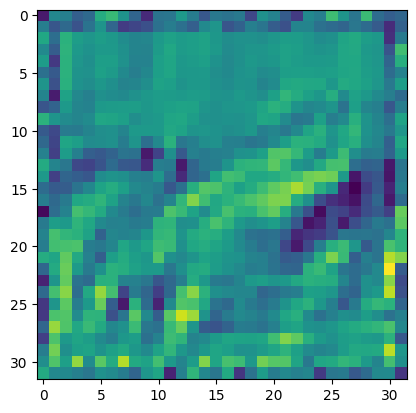

In [142]:
plt.imshow(output_deformed[10,0,:,:].detach().numpy())

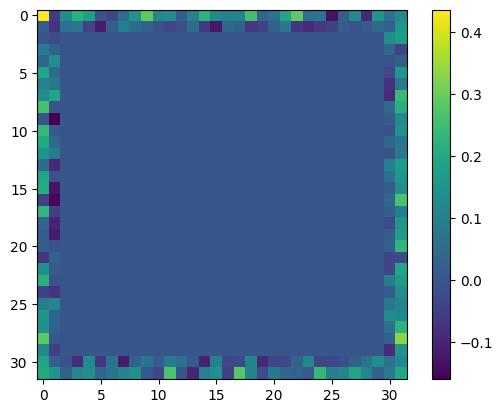

In [143]:
import matplotlib.pyplot as plt

a = output[10,0,:,:].detach() - output_deformed[10,0,:,:].detach()

plt.imshow(a.numpy())
plt.colorbar()

In [16]:

output[0,0,0,0], output_deformed[0,0,0,0]

(tensor(0.3778), tensor(0.5105))

In [302]:
import numpy as np

def get_index_conv(index, size):
    # this will return in a list, the index of all pixels that are in the convolution
    # index is the pixel target, the center of the convolution, like [5,5]
    # the convolution is size x size

    index_range = range(-(size // 2), size // 2 + 1)
    return [[index[0] + i, index[1] + j] for i in index_range for j in index_range]
    
def calculate_index_conv(dims, stride, padding, kernel_size):
    # Calcula el tamaño de la salida de la convolución
    output_dims = (dims + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    # Crea una matriz para almacenar los índices de los píxeles centrales
    
    center_indices = np.zeros((output_dims, output_dims, 2), dtype=int)
    
    #print(-padding + kernel_size // 2)
    #print((-padding + kernel_size) // 2)
    #print(np.arange(-padding + kernel_size // 2, dims + padding - kernel_size // 2, stride)[:,
    #                          np.newaxis])
    #print(np.arange(-padding + kernel_size // 2, dims + padding - kernel_size // 2, stride)[
    #                          np.newaxis, :])


    # Calcula los índices de los píxeles centrales
    center_indices[:, :, 0] = np.arange(-padding + kernel_size // 2, dims + padding - kernel_size // 2, stride)[:,
                              np.newaxis]
    
    center_indices[:, :, 1] = np.arange(-padding + kernel_size // 2, dims + padding - kernel_size // 2, stride)[
                              np.newaxis, :]

    return center_indices

def calculate_offset(dims, stride, padding, kernel_size, permutation, batch=64):
    output_dims = (dims + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    print(output_dims)
    # generate key for the permutation of conv
    perm = utils.Permutar(output_dims, 1)
    index_positions = calculate_index_conv(dims, stride, padding, kernel_size)

    # reorder index position
    index_positions = np.transpose(index_positions, (2, 0, 1))
    print(index_positions.shape)

    # desdordenar conv
    index_positions_ = perm.desordenar(torch.from_numpy(index_positions).unsqueeze(0)).squeeze(0).numpy()

    pixel_positions = np.array([permutation.get_start_block(xi) for xi in permutation.key])

    offset = np.zeros((2 * kernel_size ** 2, output_dims, output_dims), dtype='float32')

    for i in range(output_dims):
        for j in range(output_dims):
            positions = get_index_conv(index_positions_[:, i, j], kernel_size)
            positions_ = get_index_conv(index_positions[:, i, j], kernel_size)
            #print(positions_)

            for a, pos in enumerate(positions):
                index = np.where((pixel_positions == pos).all(axis=1))[0]
                if index.size > 0:
                    fake_pos = permutation.get_start_block(index)
                    distance = np.squeeze(fake_pos) - positions_[a] 
                else:
                    distance = np.array([0, 0]) - positions_[a] - 1

                offset[a * 2, i, j] = distance[0]
                offset[a * 2 + 1, i, j] = distance[1]

    offset = np.tile(offset, [batch, 1, 1, 1])
    return torch.from_numpy(offset).float(), perm, index_positions


In [306]:
from torchvision.ops import DeformConv2d
import utils

conv = DeformConv2d(1, 1, 3, padding=1)

conv.weight.data = torch.ones_like(conv.weight.data)
conv.bias.data = torch.zeros_like(conv.bias.data)

perm = utils.Permutar(32,1)

tensor_example = torch.rand(1,1,32,32)
tensor_example_permuted = perm.desordenar(tensor_example)
offset, perm, index_positions = calculate_offset(32, 1, 1, 3, perm, 1)


output_dims =  (32 + 2 * 1 - (3 - 1) - 1) // 1 + 1
print(output_dims)
#print(tensor_example)

real_output = conv(tensor_example,torch.zeros(1, 18, 32, 32))

output_disordered = conv(tensor_example_permuted, offset)

#real_output,output_disordered

32
(2, 32, 32)
32


In [307]:
output_ordered = perm.ordenar(output_disordered)

#output_ordered

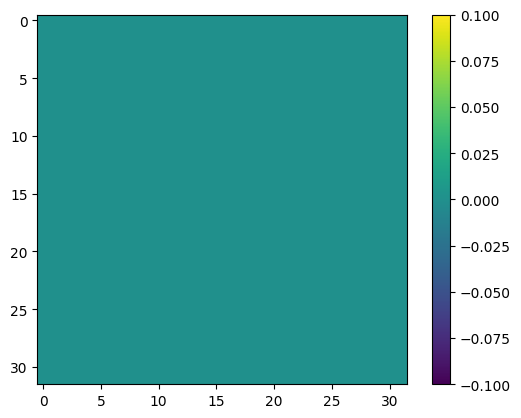

In [308]:
plt.imshow(output_ordered.squeeze().detach() - real_output.squeeze().detach())
plt.colorbar()

In [178]:
offset[0,:,0,0]

tensor([5., 2., 2., 5., 3., 5., 0., 2., 5., 6., 4., 2., 4., 3., 3., 0., 5., 1.])